<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 16 - CNNs and RNNs - Oh my
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 
    
- Finishing up our discussion of convolutional neural networks
- Important machine learning models
- Recurrent neural networks

## ``nn.Sequential`` objects
Thus far, we have created neural networks using the ``nn.Module`` base class where every layer is contained in its own attribute of the class. We may further abstract the creation of deep nets using the [``nn.Sequential`` class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The ``nn.Sequential`` class allows us to bundle a collection of layers that will be called sequentially. Thus, we can create entire blocks of layers that are assigned as their own attribute of the object. Let's look at an example CNN below.

This CNN will be a 6-layer model where the convolutional layers are organized into three blocks with a global average pooling and fully connected layer for classification. Each block will contain two convolutional layers, necessary activation layers, and a pooling layer. 

In [1]:
import torch
import torch.nn as nn

class ExampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) # global average pooling
        self.fc = nn.Linear(64, 10) # assume ten classes for this example

    def forward(self, x):
        B = x.size(0) # batch size
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).view(B, -1) # flatten to vector for features of each input in the batch
        z = self.fc(x)
        return z

In [2]:
model = ExampleCNN()
print(model)

ExampleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

We see above that the use of ``nn.Sequential`` objects simplifies the constructor and forward methods of our deep learning models. While not required, ``nn.Sequential`` objects are often good practice for PyTorch coding.

## Fully Convolutional Networks
Convolutional neural networks may be applied to many different tasks beyond simple image classification. Consider the tasks of image denoising, image super-resolution (improving resolution of images), semantic segmentation (labeling the class of every pixel in an image), and object detection (placing bounding boxes and classifiying objects in an image). The first three tasks, in particular, require producing another image. Consider the below figure depicting a semantic segmentation example.

<div>
    <center><img src="img/semantic-segmentation-example.png" width="800"></center>
</div>

Each pixel in this image is assigned its own label, like how we provide an image-level label for image classification. 

To accomplish such a task, we often use **encoder-decoder** CNN model architectures also known as **autoencoders**. The encoder stage proceeds like a normal CNN where successive convolutional layers and pooling layers reduce the spatial resolution of feature maps. The encoder and decoder stages meet at a bottleneck where the decoder stage begins upsampling the feature maps back towards the desired output resolution. Where the encoder stage applies pooling or strided convolution, the decoder stage performs **upsampling** or **transposed convolution** to increase the spatial resolution of feature maps. Finally, once the desired resolution is reached, we may use a $1\times 1$ 2D convolution layer to combine the feature maps in the last layer to provide final class scores at each pixel like how a fully connected layer does for regular image classification.

Such CNNs have no fully-connected layers (and in fact may avoid all pooling layers as well) and thus we refer to them as **fully convolutional networks** (FCN). An example autoencoder model is shown below.

<div>
    <center><img src="img/autoencoder-example.png" width="800"></center>
</div>

## Improving Model Generalization
Thus far, we have discussed the need for machine learning models to generalize to unseen validation or testing data after being fit to provided training data. We have only considered how parameters of the learning algorithm, e.g. learning rate, weight decay, momentum, or more recently how the model architecture, e.g. number of layers, width of layers, choice of pooling, etc., may be selected or tuned to search for improved model generalization. None of these changes are inherently aimed at improving generalization, but rather design choices we may iterate in hopes of gains in validation/testing performance. Next, we consider two techniques and one more common deep learning layer that help with generalization.

## Image Augmentations
One potential bottleneck that degrades model generalization is the availability of data. Deep learning models learn by recognizing common patterns in training data. The hope is that these patterns translate well to new, unseen data. With scarce data, this is quite challenging while abundant data helps capture the general distribution of information the model is being trained and thus evaluated on.

A highly popular technique for improving model generalization and robustness is the use of **augmentations**, more specifically **image augmentations** for training CNNs and other vision models. Image augmentations apply simple transformations to input data that do not affect the underlying ground-truth of the data. For example, for the task of image classification, flipping an image of a cat will not change that the image is of a cat. However, shuffling all the pixels randomly makes the image of a cat indiscernible to humans and thus not a useful image augmentation. Some common image augmentations are described below.

* **Random flipping**: Typically, this is a horizontal (left-right) flip of an image with some probability, e.g. 0.5. Some applications, for example recognizing digits or text, cannot use random flipping.
* **Random Cropping**: For some range of cropping sizes and aspect ratios, pick a random rectangle of image coordinates to crop out.
* **Blurring**: Various blurring filters may be applied to an image to distort edges or smooth information.
* **Contrast/Color Adjustments**: Many different adjustments may be made to the brightness, hue, contrast, or saturation, as well as different color adjustments, e.g. gamma correction, to change the color appearance of images.
* **Affine Transformations**: Any [translation, rotation, or shearing](https://www.mathworks.com/discovery/affine-transformation.html) of an image may be represented by an affine transformation matrix.
* **...and plenty more**: [See the PyTorch and torchvision transformations here](https://pytorch.org/vision/main/transforms.html).

Example image augmentations are depicted below.

<div>
    <center><img src="img/augmentation-examples.jpg" width="800"></center>
</div>

## Dropout
Deep learning models are often seen as over-parameterized, meaning that they have many more parameters than example data to train on. Informally speaking, this can give models a tendency to **overfit** to training data and memorize patterns in the data. The technique of **dropout** seeks to remove this dependency on memorization during training. For a given probability $p\in(0, 1)$, a dropout layer will mute or set to zero each entry in an input features map with probability $p$. Dropout seeks to reduce a model's dependency on very specific features for certain training examples and encourage more robust and generalizable feature representations.

<div>
    <center><img src="img/dropout-example.png" width="800"></center>
</div>

## Batch Norm
The activations following non-linearities in a deep net are not guaranteed to follow any "nice" distribution of values. For example, a deep net with ReLU activations will only produce positive values that may be any arbitrarily large positive number. **Batch normalization** layers attempt to rectify the distribution of activations by applying a standard normalization. During training, the activations of a given layer $Z\in\mathbb{R}^{N\times C\times H \times W}$ for $N$ examples in a batch with $C$ feature channels each of size $H\times W$ are normalized by computing the per-channel mean and standard deviation within the batch. For feature channel $c$, let the mean and standard deviation be denoted by $\mu_c$ and $\sigma_c$. We apply [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) elementwise for feature map $Z_c\in\mathbb{R}^{N\times H\times W}$ by

$$
\textrm{BatchNorm}(Z_c) = \frac{Z_c-\mu_c}{\sigma_c}*\gamma_c+\beta_c.
$$

Above, $\gamma_c$ and $\beta_c$ are learnable parameters for channel $c$ to skew the mean and standard deviation of the activations from a standard normal distribution as necessary during training. Thus, each channel has its own parameters and a batch norm layer will have $2C$ learnable parameters. During training, the model uses the batch mean and standard deviation to apply the normalization while also keeping running statistics for the dataset mean and standard deviation. At evaluation/testing time, we use the overall running statistics instead of the mini-batch statistics, which are susceptible to stochastic batch effects. In practice, batch norma has been shown to give strong improvements to CNNs and other deep net architectures, in particular for natural image datasets.

### The ``.eval()`` and ``.train()`` Methods
The above dropout and batch norm layers clearly have behavior that is unique to training versus model evaluation and testing. For example, we do not want to randomly remove a fraction of features at a particular layer when evaluating our model; this is only helpful during model training. The ``nn.Module`` class provides a simple interface to toggle our deep nets between training and evaluation model. For a deep net model named ``my_model``, we may set all layers into training mode, e.g. activate dropout, by calling ``my_model.train()``. Then, when evaluating the model, we simply call ``my_model.eval()``. We alternate between these modes when training by backpropagation and when evaluating a deep net.

## Convolutional Neural Networks History

### Image Classification
The first task to greatly benefit from the use of convolutional neural networks (CNN) was image classification. We have already seen image classification multiple times in this course. In brief, image classification takes an input image and seeks to assign one of a finite collection of labels to the image. For example, we may seek to classify images of animals as being one of: cat, dog, horse, frog, giraffe, or cow for a 6-class classification problem. The below timeline provides an incomplete set of events that greatly advanced the use of CNNs and deep learning in general.

#### LeNet (1998)
The first major practical success was the [LeNet](https://en.wikipedia.org/wiki/LeNet) (specifically LeNet-5) model developed by Yann LeCun, et al. at Bell Laboratories. LeNet was developed for handwritten digit classification on the MNIST dataset and helped automate the processing of checks and mail zip codes.
<div>
    <center><img src="img/LeNet-5.png" width="200"</center>
</div>

#### ImageNet Dataset (2009-)
The [ImageNet Dataset](https://en.wikipedia.org/wiki/ImageNet), developed by Fei-Fei Li, et al., is credited with accelerating the development of image classification models and consequently CNNs. The dataset contains multiple different tasks and has grown in size since its introduction in 2009. The most famous application of ImageNet was for the "ImageNet Large Scale Visual Recognition Challenge" (ILSVRC). While this challenge has evolved over the years, the most popularly cited version is ImageNet1k which refers to the challenge with 1,000 classes across 1,281,167 images. Example images may be easily viewed in [this GitHub repository](https://github.com/EliSchwartz/imagenet-sample-images/tree/master).

#### AlexNet (2012)
Prior to 2012, CNNs had not become too popular in the computer vision and machine learning community in spite of the success of LeNet back in 1998. Limitations on compute and specialized hardware posed a serious roadblock for developing CNNs and as such, more classical models like SVMs remained the dominant methods in the machine learning community. In 2012, [AlexNet](https://en.wikipedia.org/wiki/AlexNet) became the first CNN to win the ILSVRC competition at the CVPR 2012 conference with a top-5 error rate of 15.3%, more than 10.8% better than the runner-up. Developed by Alex Krizhevsky, Ilya Sutskever (co-founder of OpenAI), and Geoffrey Hinton (recent Nobel Prize winner), AlexNet represented a large shift in attention for researchers towards deep learning for computer vision. 

The key contributions of AlexNet were the use of deeper and larger CNNs (eight layers), ReLU non-linearity, and graphics processing units (GPU) to help with the computational burden of training such a large model on a similarly large dataset. The below figure depicts the model architectures of LeNet and AlexNet side-by-side.

<div>
    <center><img src="img/AlexNet.png" width="400"</center>
</div>

#### VGG (2014)
Following the success of AlexNet, there was increased interest in developing deeper CNN models. However, these deeper models are of course exceptionally expensive to train. The VGG-16 and VGG-19 models developed by Karen Simonyan and Andrew Zisserman of the Visual Geometry Group at University of Oxford gave a quite simple technique for effectively training deeper CNNs: just use smaller kernels! The VGG-16 and VGG-19 models only use $3\times 3$ convolutional kernels where previous models often made use of multiple larger kernel sizes.

The downside of smaller kernels is that they see less of the input image or feature map and thus have a narrower **receptive field** on their own. However, Simonyan and Zisserman showed that multiple $3\times 3$ kernel layers may actually achieve the same receptive field size as a larger kernel size with many fewer parameters. For example, consider a single convolutional layer with a $7\times 7$ kernel. For simplicity, also assume the number of input and output channels $C$ is kept the same. Thus, this layer requires $7\times 7\times C\times C=49C^2$ learnable parameters. Instead, we may stack three successive convolutional layers each with $3\times 3$ kernels (and activation functions in between). The first layer has a receptive field size of $3\times 3$. The second layer increases this receptive field to $5\times 5$, while the third layer reaches the $7\times 7$ size of the larger-kernel layer. Each of these smaller convolutional layers only requires $3\times 3\times C\times C=9C^2$ paremeters. Therefore, the entire stack of three layers takes only $27C^2$ parameters!

This simple but effective insight allows us to build deeper models with a lower burden on fitting parameters while maintaining the same ability to build feature representations at growing scales through the image. The below tables are taken from the [original VGG paper](https://arxiv.org/pdf/1409.1556).

<div>
    <center><img src="img/vgg.png" width="600"</center>
</div>

#### ResNet (2015)
As researchers made CNN models deeper, a new phenomenon was observed. While depth was helpful, there reached a point where performance would not only saturate but actual get *worse*! The below figure is taken from the original ResNet paper and demonstrates this.
<div>
    <center><img src="img/deeper-error.png" width="400"</center>
</div>

This phenomenon is counter-intuitive since an $N+L$-layer model should at least as good as an $N$-layer model. A simple thought experiment is to imagine the added $L$ layers as all performing an identity mapping, thus making the deeper and shallower models behave the same. In 2015, He, et al. argued that deeper models struggle to learn this potential identity mapping where performance begins to saturate and thus additional layers may not be necessary. This inspired the creation of the **residual unit** and the resulting ResNet model build of these residual units. Mathematically, let $\mathcal{F}(x)$ represent some function applied to input $x$. The authors claim that in deeper layers, it is quite difficult for the model (starting from some random initialization or learned set of values) to converge to an identity mapping for such an $\mathcal{F}(x)$. Instead, the authors propose the residual unit $\mathcal{H}(x)=\mathcal{F}(x)+x$ where a **skip connection** combines the input to the unit with the result of the learnable weight layers of the unit applied to that input. In this way, an identity mapping may be learned by $\mathcal{F}(x)=0$, which is easier to optimize than the very particular identity mapping. The below figure from the ResNet paper shows this residual block.
<div>
    <center><img src="img/residual-block.png" width="400"</center>
</div>

The use of residual blocks allowed for dramatically deeper models to be trained, e.g. ResNet-34 shown below from the original paper, such at ResNet-50 and ResNet-101 at the time. Today, residual blocks are at the heart of numerous successful deep learning models and are critical to the ability to train exceptional deep and large models.

<div>
    <center><img src="img/resnet-34.png" width="400"</center>
</div>

## Recurrent Neural Networks

* The deep net architectures we have explored thus far, both MLPs and CNNs, are referred to as **feed-forward** neural networks since inputs are passed to a deep net and the computation simply proceeds by a single forward pass through the model. 

* The model **has no memory or state from the previous input when receiving the next input**. This may be undesirable when processing sequence data wherein the result at one time step clearly depends on previous time steps. 

* We would like a neural network architecture that has some notion of memory/state as processing from one time step may influence processing.

Let $x\in\mathbb{R}^{T\times d}$ be an example of sequence data where $x=\{x_0, x_1, x_2, \ldots, x_{T-1}\}$ and $x_t\in\mathbb{R}^d$. For each time step, our model $f$ takes input $x_t$ and the **hidden state** of computation from previous time step $t-1$, $h_{t-1}\in\mathbb{R}^{H}$. Thus,
$$
f(x_t, h_{t-1}) = h_t.
$$

Such a model is referred to as a **recurrent neural network** (RNN) since the model's computation forms a recurrence, i.e. output at each time depends on outputs at previous times.

<div>
 <center><img src="img/rnn-unfolded.png" width="900"></center>
</div>

<img align="left" src="img/simple-rnn-model.png" width="300px" style="padding:30px;border:thin solid white;"> 


For whatever task of interest, we have a hidden state of the model at each time step that is an $H$-dimensional vector. We may then apply a fully-connected layer to these each hidden state vector for an appropriate regression or classification problem. 

The left diagram is the simplest form of RNN model. You have a input, output and a hidden state that is updated at every timestep. 

There are many other, more complex RNN models but let's stick with this one for a minute. 

## Simple PyTorch RNN model

**Problem:** Given a name (eg. "John", "Sebastion", "Yuri", etc.) we want to classify that name according to one of several categories. (adapted from [4])

**Example:** We have a dataset (https://download.pytorch.org/tutorial/data.zip) of collections of names from 19 nationalities. Examples include: 

| **Arabic** | **German** | **Irish** | **Japanese** | **Russian** |
|:----------:|:----------:|:---------:|:------------:|:-----------:|
| Nahas      | Faust      | Bran      | Akimoto      | Babinov     |
| Baz        | Heinrich   | Cassidy   | Kira         | Golovach    |
| Amari      | Tresler    | Rory      | Sakagami     | Tsalko      |

**Strategy:** We are going to pass a name into the RNN one character at a time. 

How do we pass a letter into a input that is a number/vector? 

### One hot encoding

A *one-hot vector* is filled with 0s except for a 1 at index of the current letter

**All characters:**  
`["a", "b", "c", "d", "e"]`

| Character | One-hot Vector        |
|-----------|------------------------|
| `"a"`     | [ 1, 0, 0, 0, 0 ]      |
| `"b"`     | [ 0, 1, 0, 0, 0 ]      |
| `"c"`     | [ 0, 0, 1, 0, 0 ]      |
| `"d"`     | [ 0, 0, 0, 1, 0 ]      |
| `"e"`     | [ 0, 0, 0, 0, 1 ]      |

In [1]:
# credit to [1]
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Next let's actually code up the RNN: 

In [3]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

Let's recall the RNN modle that we are trying to implement: 

<img align="center" src="img/simple-rnn-model.png" width="300px" style="padding:30px;border:thin solid white;"> 


In [4]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.Lh = nn.Linear(input_size + hidden_size, hidden_size)
        self.Lo = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.Lh(combined)
        output = self.Lo(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

Vietnamese
5000 5.0 2.6406 Mata / Japanese WRONG (Portuguese)
10000 10.0 2.0957 Sarraf / Spanish WRONG (Arabic)
15000 15.0 1.5305 Zhukovsky / Polish WRONG (Russian)
20000 20.0 0.7658 Sowka / Polish CORRECT
25000 25.0 0.1883 Roijakkers / Dutch CORRECT
30000 30.0 1.0267 Vo / Vietnamese CORRECT
35000 35.0 0.9792 Savatier / French CORRECT
40000 40.0 0.5052 Geng / Chinese CORRECT
45000 45.0 2.7566 Watt / German WRONG (Scottish)
50000 50.0 1.8093 Donoghue / Scottish WRONG (Irish)
55000 55.00000000000001 0.1416 O'Boyle / Irish CORRECT
60000 60.0 2.4069 Akera / Dutch WRONG (Japanese)
65000 65.0 1.4634 Obando / Italian WRONG (Spanish)
70000 70.0 0.4128 Pontecorvo / Italian CORRECT
75000 75.0 1.8294 Cola / Spanish WRONG (Italian)
80000 80.0 0.2716 Haddad / Arabic CORRECT
85000 85.0 2.9540 Tholberg / Russian WRONG (Dutch)
90000 90.0 0.2432 Vinh / Vietnamese CORRECT
95000 95.0 0.0359 Yakushov / Russian CORRECT
100000 100.0 1.0050 Cassidy / Irish CORRECT


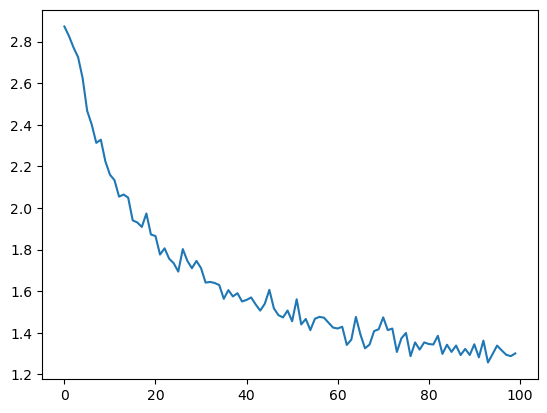

In [6]:
#code adapted from [1]

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


## Other types of RNNs

### PyTorch RNN built-in

As you probably guessed from the ``torch.nn`` library, PyTorch has a built-in RNN Module: 

In [7]:
#refer to https://github.com/patrickloeber/pytorch-examples/blob/master/rnn-lstm-gru/main.py for full test of this model/code
#[1]
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) 
        #batch_first allows us to batch our  
        # -> x needs to be: (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)         
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)   
        
        # Depending on your problem, you have to choose whether you return the last hidden state or a combination, 
        # Here we are returning the last hidden state. decode the hidden state of the last time step
        out = out[:, -1, :]
        #We need to pass our last hidden state to a fully connected layer (needs to be a logit for binary cross entropy loss function) 
        out = self.fc(out)
        return out

### Bi-directional RNN

One problem with forward only RNNs is that the next word/token always depends on the previous word/tokens. But, in many cases, a snetence can contain relevant information after the word. Consider the following sentences:  

* "An apple is something I eat everday."
* "Apple is something that simply can not be reproduced by other tech companies."

If we only evaluate the sentence left to right, "apple" will be evaluated roughly the same despite being referring to two vastly different entities.  

Enter the bidirectional LSTM. To calculate the output $y$ we: 

* Calculate the hidden layer of the forward network at every timestep
* Calculate the hidden layer of the backward network at every timestep
* Use the combination of backward and forward hidden layers to calculate the output at every timestep

<br>
<div>
 <center><img src="img/RNN-bidirectional.png" width="600"></center>
</div> Credit to [6] for the photo

Calculation is not too difficult, but PyTorch makes it super easy: 

```nn.RNN(input_size, hidden_size, bidirectional=True)```

### Stacked RNNs

Highly complex sentences require highly complex models to keep track of the different phrase compoenents. For that we have stacked RNNs:

<br>
<div>
 <center><img src="img/RNN-stacked.png" width="600"></center>
</div>

[From [7]] The reason why stacking multiple layers on top of each other is useful is for the same reason that non-linearities proved useful in the standard neural networks introduced in Section 5: they are able to progressively extract more abstract features of the current words or sentences. For example, Xing et al (EMNLP 2016) finds evidence that in a two-layer stacked LSTM, the first layer tends to learn granular features of words such as part of speech tags, while the second layer learns more abstract features of the sentence such as voice or tense.

Stacked RNNs are similarly simple to implement with Pytorch: 

```nn.RNN(input_size, hidden_size, num_layers=...[default=1])```

### Long Short-Term Memory Networks
There has been much development over the years of various fundamental layers/units that form the $f(x_t, h_{t-1})$ shown above for RNNs. The most popular such architecture is the **long short-term memory** (LSTM) RNN. There are many pieces of computation that constitute one LSTM layer or **cell**: hidden state, cell state, input gate, forget gate, cell gate, and output gate.

<div>
 <center><img src="img/lstm-cell.png" width="600"></center>
</div>

At time step $t$, the LSTM has input $x_t$, previous hidden state $h_{t-1}$, and cell state at previous time step $c_{t-1}$. The LSTM cell computes the following non-linear activation values [10]:
$$
\begin{align}
    i_t &= \sigma(W_{ii}x_t +W_{hi}h_{t-1})\in[0, 1],\quad&\textrm{Input Gate Activation}\\
    f_t &= \sigma(W_{if}x_t+W_{hf}h_{t-1})\in[0, 1],\quad&\textrm{Forget Gate Activation}\\
    g_t &= \textrm{tanh}(W_{ig}x_t+W_{hg}h_{t-1})\in[-1, 1],\quad&\textrm{Cell Gate Activation}\\
    o_t &= \sigma(W_{io}x_t + W_{ho}h_{t-1})\in[0, 1],\quad&\textrm{Output Gate Activation}
\end{align}
$$
Above, $\sigma$ denotes the sigmoid function and $\textrm{tanh}$ is the hyperbolic tangent function. The matrices $W_{ii}, W_{hi}, W_{if}, W_{hf}, W_{ig}, W_{hg}, W_{io}, W_{ho}$ represent the learnable weights in the LSTM cell. These respective gate activations control how the cell state and hidden state at the current time-step are updated. We obtain the present cell state and hidden state via:

$$
\begin{align}
    c_t &= f_t\odot c_{t-1}+i_t\odot g_t\\
    h_t &= o_t\odot\textrm{tanh}(c_t)
\end{align}
$$
where $\odot$ represents the element-wise (Hadamard) product. Intuitively, the forget gate $f_t$ allows us to remove or keep values in the cell state when entries are close to 0 or 1, respectively. The input gate activation $i_t$ represents an encoding of which entries in the cell state we may modify and to what degree since these values are between 0 and 1. Together with the cell gate activation $g_t$, which has values from -1 to 1 due to the hyperbolic tangent activation, the element-wise product of $i_t\odot g_t$ allows us to increase or decrease each value in the cell state. Altogether, these mechanisms allow us to retain, forget, or modify information in the cell state may occur from short-term or long-term dependencies in the data. Lastly, the hidden state $h_t$ uses the cell state projected between -1 to 1 by another hyperbolic tangent with one more gate activation $o_t$ to again modify or rescale the information in the cell state. It is important to note that the same weight matrices are used at each time-step.

As you probably guessed, Pytorch makes implementing LSTMs trivial: 

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0,c0))  
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]         
        out = self.fc(out)
        return out

For more discussion of LSTMs, [the following GitHub](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) contains an excellent tutorial. PyTorch also has an easy interface for implementing LSTM models using the [nn.LSTM module](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

### Gated recurrent units (GRUs)

The GRU is an optimization over the standard LSTM. It differs from the LSTM in the way the memory cell state is maintained:

* In the LSTM, the memory cell is separate from the hidden state and updated via the input, output and forget gates. 
* In the GRU the memory cell is replaced with a "candidate activation vector" which is updated via the reset and update gates. 

<br>
<div>
 <center><img src="img/GRU_overview.png" width="500"></center>
</div> [8]

The reset gate determines how much of the previous hidden state to forget, while the update gate determines how much of the candidate activation vector to incorporate into the new hidden state. Read more about the specific mathematics of the GRU in [9]

And again, implementing the GRU in PyTorch following the same pattern as the others.

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)#############
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.gru(x, h0)  ###############
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## Unreasonable effectiveness of RNN models

Most problems can be reformulated as recurrent neural network problems!

<br>
<br>

<div>
 <center><img src="img/rnn_problems.jpeg" width="600"></center>
</div>

[3]

Some examples of each category type: 

1. One-to-one - Image classification - Given the MNIST dataset, determine what digit the image represents - https://medium.com/@abhinav.mishra123/building-a-recurrent-neural-network-rnn-with-pytorch-9358a696d7dc
2. One-to-many - Image captioning - Generate a multi-token textual description of an image - https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3
3. Many-to-one - Sentiment Classification - given a multi-token piece of text, such as a product review, output whether is is positive/negative/etc. https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb
4. Many-to-many (out-of-phase) - Machine translation - translate text between two languages - https://www.kaggle.com/code/harshjain123/machine-translation-seq2seq-lstms
5. Many-to-many (in-phase) - Part-of-speech tagging - Given a multi-word sentence, determine if each word is a noun, verb, etc. - https://goodboychan.github.io/python/deep_learning/tensorflow-keras/2020/12/09/01-RNN-Many-to-many.html
 

## That's it for today 

- Project descriptions will be posted in next couple days (issue with Kaggle we are working to get sorted). 
- Remember HW7 has been posted. Back to the grind. Work hard. Don't go insane. 

## References

[1] Patrick Loeber's tutorials on RNNs - https://www.youtube.com/watch?app=desktop&v=WEV61GmmPrk

[2] Roger Grosse CSC321 lectures - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/

[3] Andrej Karpathy, "The Unreasonable Effectiveness of Recurrent Neural Networks" https://karpathy.github.io/2015/05/21/rnn-effectiveness/ 

[4] "NLP From Scratch: Classifying Names with a Character-Level RNN" - https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

[5] Learn with Jay "Bidirectional RNN | Deep Learning | In-depth Explanation & Equations" - https://www.youtube.com/watch?v=f6DwK5Kuv3E

[6] Colah's blog "Neural Networks, Types, and Functional Programming" - https://colah.github.io/posts/2015-09-NN-Types-FP/

[7] Phontron "Language Models 4: Recurrent Neural Network Language Models" - https://www.phontron.com/class/mtandseq2seq2018/assets/slides/mt-fall2018.chapter6.pdf

[8] Ivan Vasilev "Advanced deep learning with Python" - https://www.oreilly.com/library/view/advanced-deep-learning/9781789956177/8ad9dc41-3237-483e-8f6b-7e5f653dc693.xhtml

[9] Chung et al. "Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling" - https://arxiv.org/abs/1412.3555

[10] DagsHub "Complete Guide to RNN, LSTM, and Bidirectional LSTM" - https://dagshub.com/blog/rnn-lstm-bidirectional-lstm/